In [2]:
import datasets

import nibabel as nib
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np

import draw_results
import gene_analysis
import removing_confound
import meta_roi
import meta_voxel
import meta_vertex
import meta_confound
import correlation
from mask import Mask, NiiMask
import mixed_lm

D:\Software\conda\envs\meta\lib\site-packages\nilearn\datasets\__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
#Assume all data is organized
#Load dataset
centers = datasets.load_centers_all()

#Define ROI Mask
mask_path = './data/mask/rBN_Atlas_246_1mm.nii'
mask = NiiMask(mask_path)

label_pairs = [(2,0), (2,1), (1,0)]

# Create ROI csv, and remove confound for each center

In [3]:
"""
#Create ROI GMV/CT csv file
for center in centers:
    center.create_rgmv_csv(mask, gmv_csv_prefix='roi_gmv/{}.csv')
    center.create_rct_csv()
"""
#Remove confound
# ROI
removing_confound.remove_roi(centers)
removing_confound.remove_roi(centers, csv_prefix='roi_ct/{}.csv',
                                out_prefix='roi_ct_removed/{}.csv')
"""
# Voxel
centers = datasets.load_centers_edsd()
removing_confound.remove_nii(centers, mask, batch_reg=False)
centers = datasets.load_centers_mcad()
removing_confound.remove_nii(centers, mask, batch_reg=False)
centers = datasets.load_centers_adni()
removing_confound.remove_nii(centers, mask, batch_reg=True, batch_size=4000000)

# Vertex
centers = datasets.load_centers_all()
removing_confound.remove_gii(centers)
"""

MCAD\AD_S01
loading x
loading y
Regression
Write New Data
MCAD\AD_S02
loading x
loading y
Regression
Write New Data
MCAD\AD_S03
loading x
loading y
Regression
Write New Data
MCAD\AD_S04
loading x
loading y
Regression
Write New Data
MCAD\AD_S05
loading x
loading y
Regression
Write New Data
MCAD\AD_S06
loading x
loading y
Regression
Write New Data
MCAD\AD_S07
loading x
loading y
Regression
Write New Data
MCAD\AD_S08
loading x
loading y
Regression
Write New Data
EDSD\AMS
loading x
loading y
Regression
Write New Data
EDSD\BRE
loading x
loading y
Regression
Write New Data
EDSD\CAM
loading x
loading y
Regression
Write New Data
EDSD\DUB
loading x
loading y
Regression
Write New Data
EDSD\FRA
loading x
loading y
Regression
Write New Data
EDSD\FRE
loading x
loading y
Regression
Write New Data
EDSD\MAI
loading x
loading y
Regression
Write New Data
EDSD\MAN
loading x
loading y
Regression
Write New Data
EDSD\MIL
loading x
loading y
Regression
Write New Data
EDSD\MUN
loading x
loading y
Regression
W

'\n# Voxel\ncenters = datasets.load_centers_edsd()\nremoving_confound.remove_nii(centers, mask, batch_reg=False)\ncenters = datasets.load_centers_mcad()\nremoving_confound.remove_nii(centers, mask, batch_reg=False)\ncenters = datasets.load_centers_adni()\nremoving_confound.remove_nii(centers, mask, batch_reg=True, batch_size=4000000)\n\n# Vertex\ncenters = datasets.load_centers_all()\nremoving_confound.remove_gii(centers)\n'

# Perform meta-analysis

## ROI

In [4]:
# ROI
csv_prefixs = ['roi_gmv' ,'roi_ct', 'roi_gmv_removed', 'roi_ct_removed']

# Create csv for meta analysis
for csv_prefix in csv_prefixs:
    for label_pair in label_pairs:
        label_eg = label_pair[0]
        label_cg = label_pair[1]
        meta_roi.create_csv_for_meta(centers, label_eg, label_cg, csv_prefix)
#%%
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    # GMV meta-analysis
    meta_roi.meta_gmv(label_eg, label_cg, mask, csv_prefix='roi_gmv')
    meta_roi.meta_gmv(label_eg, label_cg, mask, csv_prefix='roi_gmv_removed')
    # CT meta-analysis
    meta_roi.meta_ct(label_eg, label_cg, csv_prefix='roi_ct', mask=mask, save_gii=False, save_nii=True)
    meta_roi.meta_ct(label_eg, label_cg, csv_prefix='roi_ct_removed', mask=mask, save_gii=False, save_nii=True)

# Plot correlation between each center

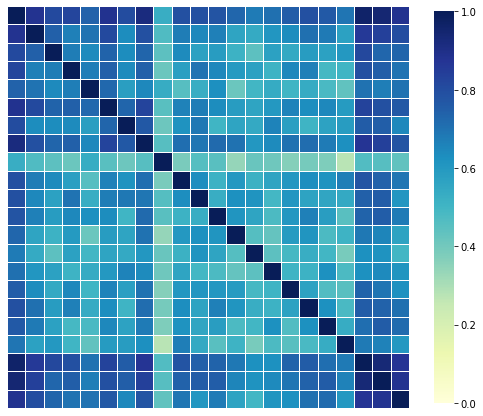

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create Dataframe with full sites
es_df_columns = ['Total']
for center in centers:
    es_df_columns.append(center.name)

roi_count = 246
es_df = pd.DataFrame(columns=es_df_columns, index=[i for i in range(1, roi_count+1)])

# perform meta_analysis
result_models = meta_roi.meta_gmv(2, 0, mask, save_nii=False,
                                  csv_prefix='roi_gmv_removed')
for roi in range(1, roi_count+1):
    values = [result_models[roi].total_effect_size]
    for center in centers:
        value = np.NaN
        for study, es in zip(result_models[roi].studies, result_models[roi].effect_sizes):
            if center.name == study.name:
                value = es
        values.append(value)
    es_df.loc[roi] = values
es_df = es_df.astype(np.float32)
es_df = es_df.dropna(axis=1, how='any')

corr_df = es_df.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.color_palette("cubehelix_r", as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_df, cmap='YlGnBu', vmin=0, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
ax.axis('off')
plt.show()

# Center heterogeneity

In [ ]:
label_eg = 2
label_cg = 0
# GMV meta-analysis
result_models = meta_roi.meta_gmv(label_eg, label_cg, mask,
                                 save_nii=False,csv_prefix='roi_gmv_removed')
from draw_results import plot_correlation
ess = []
heters = []
for k, model in result_models.items():
    ess.append(model.total_effect_size)
    heters.append(model.q)
plot_correlation(ess, heters)

In [ ]:
# Check how many ROI pass correction
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    # GMV meta-analysis
    roi_models =meta_roi.meta_gmv(label_eg, label_cg, mask, csv_prefix='roi_gmv_removed')
    #roi_models = meta_roi.meta_ct(label_eg, label_cg, csv_prefix='roi_ct_removed', mask=mask, save_gii=False, save_nii=False)
    i = 0
    for key, model in roi_models.items():
        if model.p < 0.001/246:
            i += 1
    print(i)

In [ ]:
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    # CT meta-analysis
    roi_models = meta_roi.meta_ct(label_eg, label_cg, csv_prefix='roi_ct_removed', mask=mask, save_gii=False, save_nii=False)
    i = 0
    for key, model in roi_models.items():
        if model.p < 0.001/246:
            i += 1
    print(i)

## Voxel and Vertex

In [3]:
# Voxel
# Create center mean std nii file
labels = [0, 1, 2]

for center in centers:
    temp_nii = nib.load('./data/mask/save_temp.nii')
    for label in labels:
        center.create_stat_nii(label, temp_nii, nii_dir='mri_smoothed')

# perform meta-analysis
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    meta_voxel.meta_nii(centers, label_eg, label_cg, mri_dir='mri_smoothed')

D:\Software\conda\envs\meta\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Software\conda\envs\meta\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Software\conda\envs\meta\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
D:\Software\conda\envs\meta\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
D:\Software\conda\envs\meta\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Software\conda\envs\meta\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Software\conda\envs\meta\lib\site-packages\numpy\core\_methods.py:189: RuntimeW

In [14]:
"""
# Vertex
# Create center mean std numpy file
labels = [0,1,2]
for center in centers:
    for label in labels:
        center.create_stat_gii(label, prefix='surf/s15.mesh.thickness.resampled_32k.{}.gii')
"""
# perform meta-analysis for resampled surface
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    meta_vertex.meta_gii(centers, label_eg, label_cg)

# personal score

In [4]:
from data_harmonization import neurocombat

neurocombat(centers, personal_info_prefix = 'personal_info/{}.csv',
                cat_prefix = 'report/cat_{}.xml',
                csv_prefix = 'roi_gmv/{}.csv',
                out_prefix = 'neurocombat_gmv/{}.csv')
neurocombat(centers, personal_info_prefix = 'personal_info/{}.csv',
                cat_prefix = 'report/cat_{}.xml',
                csv_prefix = 'roi_ct/{}.csv',
                out_prefix = 'neurocombat_ct/{}.csv')

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [5]:
# Create stats csv for each label
from personal_scores import create_stats_csv, cal_personal_scores

create_stats_csv(centers, 'neurocombat_gmv', out_dir='./data/stats', divide_tiv=False)
cal_personal_scores(centers, stats_dir='./data/stats/neurocombat_gmv',
                     csv_prefix='neurocombat_gmv/{}.csv', out_prefix='personal_scores/{}.csv')


In [ ]:
from personal_scores import plot_stats
ax, legends = plot_stats('./data/stats/roi_gmv', 217)
import matplotlib.pyplot as plt
ax.legend(legends)
plt.show()

### Subtype based on personal scores -> see subtype_unsupervised.py

## Confound

In [ ]:
# Create csv for meta analysis
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    meta_confound.create_csv_for_meta(centers, label_eg, label_cg)

for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    meta_confound.meta_confound(label_eg, label_cg)

# PET: ABeta

In [6]:
# abeta PET correlation
from abeta_pet import ttest_by_label
import utils
out_dir_prefix = './results/correlation/{}_{}'

for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    t, p = ttest_by_label(label_eg, label_cg)

    roi_models = meta_roi.meta_gmv(label_eg, label_cg, mask, save_nii=False)
    es1 = [v.total_effect_size for k,v in sorted(roi_models.items())]
    es2 = [v for k,v in sorted(t.items())]
    draw_results.plot_correlation_joint(es1, es2,
        'Effect sizes of ROI GMV', 't-values of ROI Aβ', fontsize=18, show=False,
        save=True, out_path=os.path.join(out_dir_prefix.format(label_eg, label_cg), 'gmv', 'abeta.png'))

    roi_models = meta_roi.meta_ct(label_eg, label_cg, mask, save_nii=False, save_gii=False)
    es1 = [v.total_effect_size for k,v in sorted(roi_models.items()) if int(k)<211]
    es2 = [v for k,v in sorted(t.items()) if int(k)<211]
    draw_results.plot_correlation_joint(es1, es2,
        'Effect sizes of ROI CT', 't-values of ROI Aβ', fontsize=18, show=False,
        save=True, out_path=os.path.join(out_dir_prefix.format(label_eg, label_cg), 'ct', 'abeta.png'))

h:\workspace\AD_meta\abeta_pet.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  subject_df[str(i+1)] = roi


In [ ]:
from abeta_pet import create_subject_df 
df = create_subject_df()
len(df)

# PET: FDG

In [7]:
from pet_fdg import ttest_by_label
out_dir_prefix = './results/correlation/{}_{}'

for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    t, p = ttest_by_label(label_eg, label_cg)

    roi_models = meta_roi.meta_gmv(label_eg, label_cg, mask, save_nii=False)
    es1 = [v.total_effect_size for k,v in sorted(roi_models.items())]
    es2 = [v for k,v in sorted(t.items())]
    draw_results.plot_correlation_joint(es1, es2,
        'Effect sizes of ROI GMV', 't-values of ROI FDG', fontsize=18, show=False,
        save=True, out_path=os.path.join(out_dir_prefix.format(label_eg, label_cg), 'gmv', 'FDG.png'))
    
    roi_models = meta_roi.meta_ct(label_eg, label_cg, mask, save_nii=False, save_gii=False)
    es1 = [v.total_effect_size for k,v in sorted(roi_models.items()) if int(k)<211]
    es2 = [v for k,v in sorted(t.items()) if int(k)<211]
    draw_results.plot_correlation_joint(es1, es2, 
        'Effect sizes of ROI CT', 't-values of ROI FDG', fontsize=18, show=False,
        save=True, out_path=os.path.join(out_dir_prefix.format(label_eg, label_cg), 'ct', 'FDG.png'))

In [ ]:
from pet_fdg import create_subject_df 
df = create_subject_df()
len(df)

# PET:Juspace

In [36]:
pet_dir = './data/PET/masked_mean'
out_dir_prefix = './results/correlation/{}_{}/{}/PET'
labels = ['NC', 'MCI', 'AD']

df = pd.DataFrame(columns = ['x', 'y', 'Pearson\'s r', 'Size', 'p'])
x_labels = []
y_labels = []
label_pairs = [(1,0), (2,1), (2,0)]

y = 1
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    roi_gmv_models = meta_roi.meta_gmv(label_eg, label_cg, mask, save_nii=False)
    roi_ct_models = meta_roi.meta_ct(label_eg, label_cg, save_gii=False, save_nii=False)

    gmv_out_dir = out_dir_prefix.format(label_eg, label_cg, 'gmv')
    ct_out_dir = out_dir_prefix.format(label_eg, label_cg, 'ct')
    if not os.path.exists(gmv_out_dir):
        os.mkdir(gmv_out_dir)
    if not os.path.exists(ct_out_dir):
        os.mkdir(ct_out_dir)

    gmv_results = correlation.cor_roi_pet(roi_gmv_models, pet_dir, out_dir=gmv_out_dir,
                                        fig_width=5, fig_height=5,
                                        fontsize=18, save=True, show=False)
    ct_results = correlation.cor_roi_pet(roi_ct_models, pet_dir, out_dir=ct_out_dir,
                                        fig_width=5, fig_height=5,
                                        fontsize=18,  save=True, show=False)
    if not x_labels:
        for result in gmv_results:
            x_labels.append(result.name)
    y_labels.append('{}_{}_CT'.format(labels[label_eg], labels[label_cg]))
    y_labels.append('{}_{}_GMV'.format(labels[label_eg], labels[label_cg]))
    
    x = 1
    for result in ct_results:
        df = df.append({'x' : x, 'y' : y, 'Pearson\'s r' : result.r,
                        'Size':abs(result.r), 'p': result.p, '-log10 p':-np.log10(result.p)}, 
                        ignore_index = True) 
        x += 1

    x = 1
    for result in gmv_results:
        df = df.append({'x' : x, 'y' : y+1, 'Pearson\'s r' : result.r,
                        'Size':abs(result.r), 'p': result.p, '-log10 p':-np.log10(result.p)}, 
                        ignore_index = True) 
        x += 1
    y += 2

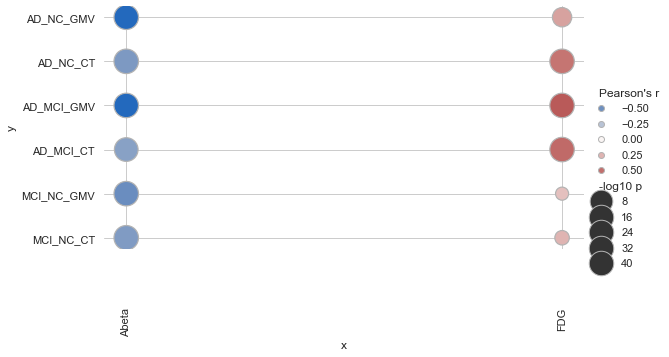

In [35]:
import matplotlib.pyplot as plt
def draw_pet_relplot(df, x_labels, y_labels):
    # Draw each cell as a scatter point with varying size and color
    sns.set_theme(style="whitegrid")
    g = sns.relplot(
        data=df, height=4, aspect=1.8,
        x="x", y="y", hue="Pearson\'s r", size="-log10 p",
        palette="vlag", hue_norm=(-0.7, 0.7), edgecolor=".7",
        sizes=(0, 600), size_norm=(0, 10))

    g.ax.set_xticks(np.arange(1, len(x_labels)+1))
    g.ax.set_xticklabels(x_labels)

    g.ax.set_yticks(np.arange(1, len(y_labels)+1))
    g.ax.set_yticklabels(y_labels)
    
    g.despine(left=True, bottom=True)

    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
        x, y = label.get_position()
        label.set_position((x, y-0.2))
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")

    #plt.savefig(r'D:\Desktop\abeta_fdg.png', dpi=600)
    plt.show()
    
draw_pet_relplot(df, x_labels, y_labels)

In [34]:
import abeta_pet
import pet_fdg
import correlation

labels = ['NC', 'MCI', 'AD']

df = pd.DataFrame(columns = ['x', 'y', 'Pearson\'s r', 'Size', 'p'])
x_labels = []
y_labels = []
label_pairs = [(1,0), (2,1), (2,0)]

y = 1
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    roi_gmv_models = meta_roi.meta_gmv(label_eg, label_cg, mask, save_nii=False)
    roi_ct_models = meta_roi.meta_ct(label_eg, label_cg, save_gii=False, save_nii=False)

    gmv_es_dict = {}
    for key, roi_gmv_model in roi_gmv_models.items():
        gmv_es_dict[key] = roi_gmv_model.total_effect_size
        
    ct_es_dict = {}
    for key, roi_ct_model in roi_ct_models.items():
        ct_es_dict[key] = roi_ct_model.total_effect_size

    abeta_t, _ = abeta_pet.ttest_by_label(label_eg, label_cg)
    fdg_t, _ =  pet_fdg.ttest_by_label(label_eg, label_cg)
    
    gmv_results = [correlation.pearson_r('Abeta', gmv_es_dict, abeta_t), 
                   correlation.pearson_r('FDG', gmv_es_dict, fdg_t)]
    ct_results = [correlation.pearson_r('Abeta', ct_es_dict, abeta_t), 
                   correlation.pearson_r('FDG', ct_es_dict, fdg_t)]

    if not x_labels:
        for result in gmv_results:
            x_labels.append(result.name)
    y_labels.append('{}_{}_CT'.format(labels[label_eg], labels[label_cg]))
    y_labels.append('{}_{}_GMV'.format(labels[label_eg], labels[label_cg]))
    
    x = 1
    for result in ct_results:
        df = df.append({'x' : x, 'y' : y, 'Pearson\'s r' : result.r,
                        'Size':abs(result.r), 'p': result.p, '-log10 p':-np.log10(result.p)}, 
                        ignore_index = True) 
        x += 1

    x = 1
    for result in gmv_results:
        df = df.append({'x' : x, 'y' : y+1, 'Pearson\'s r' : result.r,
                        'Size':abs(result.r), 'p': result.p, '-log10 p':-np.log10(result.p)}, 
                        ignore_index = True) 
        x += 1
    y += 2

h:\workspace\AD_meta\abeta_pet.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  subject_df[str(i+1)] = roi


# PLSR with Gene

In [3]:
n_perm_boot = 5000
n_components = 5
out_dir_prefix ='./results/gene/{}_{}'
label_pairs = [(2,0)]
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    out_dir = out_dir_prefix.format(label_eg, label_cg)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    roi_gmv_models = meta_roi.meta_gmv(label_eg, label_cg, mask, save_nii=False)
    roi_ct_models = meta_roi.meta_ct(label_eg, label_cg, save_gii=False, save_nii=False)
    
    gmv_es_dict = {}
    for k,v in sorted(roi_gmv_models.items()):
        gmv_es_dict[int(k)] = v.total_effect_size
        
    ct_es_dict = {}
    for k,v in sorted(roi_ct_models.items()):
        ct_es_dict[int(k)] = v.total_effect_size
    print('model calculated')
    gmv_plsr = gene_analysis.plsr(gmv_es_dict, n_components=n_components,
                                  n_perm=n_perm_boot, n_boot=n_perm_boot,
                                  out_path=os.path.join(out_dir, 'plsr_gmv.csv'))
    print('GMV Finished')
    ct_plsr = gene_analysis.plsr(ct_es_dict, n_components=n_components,
                                  n_perm=n_perm_boot, n_boot=n_perm_boot,
                                  out_path=os.path.join(out_dir, 'plsr_ct.csv'))

    with open(os.path.join(out_dir, 'plsr_gmv.pickle'), 'wb') as f:
        pickle.dump(gmv_plsr, f)
    with open(os.path.join(out_dir, 'plsr_ct.pickle'), 'wb') as f:
        pickle.dump(ct_plsr, f)

model calculated


GMV Finished


## Check PLSR models

In [6]:
# Check plsr model
result_plsr_dir = './results/gene/2_0'
with open(os.path.join(result_plsr_dir, 'plsr_gmv.pickle'), 'rb') as f:
    gmv_plsr = pickle.load(f)
with open(os.path.join(result_plsr_dir, 'plsr_ct.pickle'), 'rb') as f:
    ct_plsr = pickle.load(f)
    
print('GMV: variance_explained:{:.2f} ,p:{:.2e}'.format(gmv_plsr.varexp[0] , gmv_plsr.permres.pvals[0]))
print('CT: variance_explained:{:.2f} ,p:{:.2e}'.format(ct_plsr.varexp[0] , ct_plsr.permres.pvals[0]))

GMV: variance_explained:0.42 ,p:2.00e-04
CT: variance_explained:0.25 ,p:2.00e-04


In [ ]:
gmv_plsr.permres.pvals

# Robustness of PLSR

In [ ]:
# Take 80% subjects for meta then performed PLSR
label_eg = 2
label_cg = 0
for i in range(5000):
    roi_gmv_models = meta_roi.create_csv_for_meta(centers, label_eg, label_cg,
                                    csv_prefix='roi_gmv_removed',
                                    out_path=os.path.join('./data/meta_csv/robust', str(i)),
                                    ratio=0.8)

In [ ]:
for i in range(5000):
    print(i)
    roi_gmv_models = meta_roi.meta_gmv(2, 0, mask,
                                    csv_dir=f'./data/meta_csv/robust/{i}',
                                    out_dir='./results/robust',
                                    save_nii=False)
    with open(f'./results/robust/result_models_{i}.pkl', 'wb') as f:
        pickle.dump(roi_gmv_models, f)

In [4]:
from scipy.stats import pearsonr
import pickle

main_models = meta_roi.meta_gmv(2, 0, mask, csv_prefix='roi_gmv_removed')
main_ess = [model.total_effect_size for k, model in main_models.items()]
rs = []
for i in range(5000):
    with open(f'./results/robust/result_models_{i}.pkl', 'rb') as f:
        roi_gmv_models = pickle.load(f)
        ess = [model.total_effect_size for k,model in roi_gmv_models.items()]
        r,p = pearsonr(main_ess, ess)
        rs.append(r)
with open(f'./results/robust/rs.pkl', 'wb') as f:
    pickle.dump(rs, f)

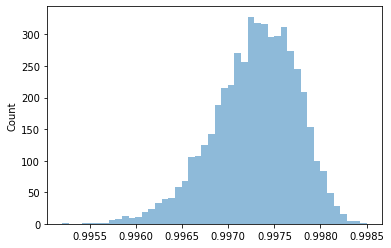

In [4]:
import pickle
with open(f'./results/robust/rs.pkl', 'rb') as f:
    rs = pickle.load(f)
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x=rs, fill=True,
            alpha=.5, linewidth=0,)
plt.show()

In [ ]:
from scipy.stats import pearsonr
import pandas as pd
df = pd.read_csv('./results/gene/2_0/plsr_gmv.csv', index_col=0)
values = df['pls1'].values
rs = []
for i in range(5000):
    print(i)
    tmp_df = pd.read_csv(f'./results/robust/plsr/plsr_gmv_{i}.csv', index_col=0)
    tmp_values = tmp_df['pls1'].values
    r,p = pearsonr(values, tmp_values)
    rs.append(r)
import pickle
with open(f'./results/robust/rs_plsr.pkl', 'wb') as f:
    pickle.dump(rs, f)

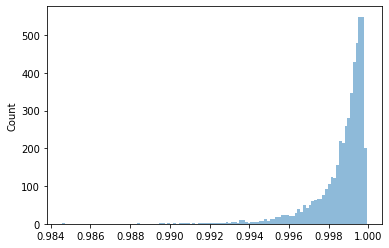

In [1]:
import pickle
import numpy as np
with open(f'./results/robust/rs_plsr.pkl', 'rb') as f:
    rs = pickle.load(f)
rs = np.abs(rs)
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x=rs, fill=True,
            alpha=.5, linewidth=0,)
plt.show()

# Personal Scores & Subtypes

In [8]:
from data_harmonization import neurocombat
neurocombat(centers, personal_info_prefix = 'personal_info/{}.csv',
                cat_prefix = 'report/cat_{}.xml',
                csv_prefix = 'roi_ct/{}.csv',
                out_prefix = 'neurocombat_ct/{}.csv')

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [9]:
# Use harmonized data
# Already Controlled For Age Gender TIV
from personal_scores import create_stats_csv
create_stats_csv(centers, 'neurocombat_gmv', out_dir='./data/stats/', divide_tiv=False)
create_stats_csv(centers, 'neurocombat_ct', out_dir='./data/stats/', divide_tiv=False)

247
247
247
211
211
211


In [3]:
import personal_scores
import importlib
importlib.reload(personal_scores)
personal_scores.cal_personal_scores(centers, './data/stats/neurocombat_gmv',
                    'neurocombat_gmv/{}.csv', 'personal_scores/{}.csv')

In [ ]:
import personal_scores
import importlib
importlib.reload(personal_scores)
personal_scores.cal_personal_scores(centers, './data/stats/neurocombat_ct',
                    'neurocombat_ct/{}.csv', 'personal_scores_ct/{}.csv')

## Subtype analysis see subtype_unsupervised.py

In [1]:
from draw_center_summary import get_center_stats
get_center_stats(csv_path='./results/s.csv')

MCAD 0
MCAD 1
MCAD 2
ADNI 0
ADNI 1
ADNI 2
EDSD 0
EDSD 1
EDSD 2


,Male,Female,ages_mean,ages_std,mmses_mean,mmses_std,csfs_mean,csfs_std,gmvs_mean,gmvs_std,wmvs_mean,wmvs_std,tivs_mean,tivs_std
0,147.0,188.0,64.710448,8.857228,28.600000,1.578210,378.407575,77.979905,590.894724,53.096343,492.837801,54.241709,1463.449425,140.815645
1,138.0,162.0,68.493333,9.264086,25.146667,3.492634,419.421267,94.805143,563.375270,59.650053,471.966843,56.381031,1456.951148,146.721480
2,154.0,245.0,69.228070,9.147941,16.671679,5.962706,459.672948,96.598422,524.458289,63.468180,442.927021,57.267773,1430.555682,141.686080
3,278.0,322.0,73.484000,6.113985,29.086667,1.093537,392.915092,87.081018,549.016710,53.221221,478.654837,62.076641,1425.325039,154.980623
4,412.0,283.0,73.225324,7.661581,27.458993,1.822553,432.705054,96.642130,532.982351,54.903806,477.067643,64.100244,1448.685739,156.123862
5,147.0,130.0,74.864621,7.754913,23.144404,2.112558,473.729479,103.394721,499.522494,54.857582,455.181091,62.803925,1436.651167,176.914913
6,98.0,116.0,68.790467,6.185989,28.822430,1.142330,355.418527,73.828516,551.603515,53.148382,487.785656,63.811371,1398.911961,149.442158
7,76.0,64.0,72.800000,6.607571,26.278571,2.080755,431.410909,82.764789,516.460010,55.708581,458.482994,64.115596,1413.026853,152.656923
8,67.0,91.0,72.561203,8.057689,20.962025,5.032661,439.903494,71.311132,478.771385,56.364869,432.804932,67.578743,1358.198462,152.106409
